# 经典分割一致性预测（Classical Split Conformal Prediction）

本笔记本展示了如何 从零开始实现 Split Conformal Prediction（分割一致性预测）。这是一种 简单且直观的方法，可以提供 固定宽度的预测区间，并且具有 理论覆盖率保证。

该方法的核心思想是 在校准集（Calibration Set）上估计均值绝对误差（Mean Absolute Error, MAE）分布的分位数，从而构造预测区间。

简而言之，我们将从头开始 实现 MAPIE 库的默认 “绝对残差评分”（Absolute Residual Scores）[absolute residual scores from MAPIE](https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html) ，并验证我们实现的结果是否与 MAPIE 提供的实现一致。


有关该方法的详细数学描述，请参见以下论文的 第 2.2 节:

*Lei, J., G’Sell, M., Rinaldo, A., Tibshirani, R. J., & Wasserman, L. (2018). Distribution-Free Predictive Inference for Regression. Journal of the American Statistical Association, 113(523), 1094–1111. Available from https://doi.org/10.1080/01621459.2017.1307116*

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from util import regression_plot_with_uncertainty

Since we have to plot a lot of prediction bands, let us define a utility function for obtaining them from the predictive mean and the absolute error quantiles.
由于需要绘制大量的预测区间，定义一个实用函数（utility function），用于从预测均值（predictive mean）和绝对误差分位数（absolute error quantiles）中获取预测区间

In [3]:
def construct_prediction_bands(mean_prediction, quantiles): #两个参数，分别是预测均值（真实值）和绝对误差分位数
    """
    一个函数，用于返回每个分位数（quantiles）对应的下预测区间（lower prediction band）和上预测区间（upper prediction band）
    """
    
    prediction_bands = np.zeros((len(mean_prediction), 2, len(quantiles))) #创建一个三维数组

    for i, q in enumerate(quantiles): #遍历数组quantiles，i为索引，q为分位数值
        prediction_bands[:, :, i] = np.stack([
            mean_prediction - q,
            mean_prediction + q
        ], axis=1) #对于每个分位数，计算下预测区间mean_prediction - q和上预测区间mean_prediction + q，并将他们沿第二个轴堆叠在一起。结果存储在prediction_bands的相应位置

    return prediction_bands

## 生成具有同方差噪声（Homoscedastic Noise）的示例数据集（Toy Dataset）

从一个线性模型f(x)中采样数据，并添加同方差噪声（Homoscedastic Noise），其标准差为$\sigma$。其中x由区间[0, 1]内等间距输入组成。

In [4]:
def f(x):
    """用于生成一维数据的线性函数"""
    return np.array(5 * x + 2)

In [5]:
def generate_homoscedastic_data(n_samples, sigma=0.1, random_state=42): #生成同方差数据，三个参数为样本数，标准差，随机种子
    """
    从给定的函数生成一维数据，并添加指定标准差的噪声。
    """
    np.random.seed(random_state) #设置随机种子
    X = np.linspace(0, 1, n_samples)[:, np.newaxis] #X为从0到1的等差数列，n_samples为样本数，np.newaxis为增加一个维度（转化为列向量）
    y = f(X) + np.random.normal(0, sigma, (n_samples, 1)) #y为X对应的函数值加上服从正态分布的噪声，均值为0，标准差为sigma
    y_gt = f(X) #y_gt为真实的函数值（无噪声的X对应的函数值）
    return X, y.ravel(), y_gt.ravel() #返回X，y，y_gt，其中两个y展平为一维数组

使用$\sigma=0.5$生成数据

In [6]:
sigma = 0.5 #设置噪声的标准差
X, y, y_gt = generate_homoscedastic_data(n_samples=500, sigma=sigma, random_state=42) #生成同方差数据，X为特征（0~1共500），y为带噪声函数输出，y_gt为真实函数输出

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) #划分训练集和测试集，测试集占10%
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #在训练集中划分出10%作为校准集

绘制真实函数（ground-truth function）及其采样分布的 95% 真实预测区间（ground-truth 95% prediction intervals）。此外还在图中添加一些测试点，以验证大约 95% 的测试点确实落在误差区间内。

In [7]:
print(f'Expected number of points outside the 95% error bars: {len(X_cal) * 0.05}')

Expected number of points outside the 95% error bars: 4.5


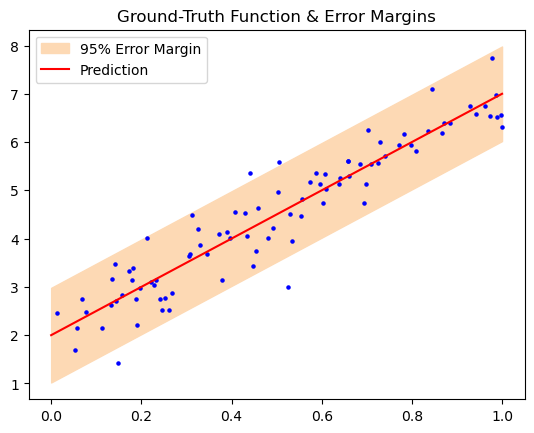

In [ ]:
#绘制带有不确定性预测区间的回归图，这里红线是真实函数值，蓝色散点是带噪声的函数输出（只取校准集部分），黄色是95%估计误差，来源于真实值和绝对误差分位数

fig, ax = plt.subplots(1, 1)
#计算标准正态分布（当\sigma=1.0时）的第97.5百分位数。
q975 = scipy.stats.norm.ppf(0.975)
# 由于使用y_gt + N(0, sigma)来采集数据，因此alpha=0.05的预测区间应为[y_gt - sigma * q975, y_gt + sigma * q975]
# 这里q025 = -q975是因为标准正态分布是对称的
prediction_bands = construct_prediction_bands(y_gt, [sigma * q975]) #构造不确定性预测区间，来自于自定义函数，分位数是sigma * q975
regression_plot_with_uncertainty(ax, X, y_gt, prediction_bands, (X_cal, y_cal), labels=['95% Error Margin']) #绘制回归图，包括真实函数值，不确定性预测区间，校准集，标签为95%估计误差
ax.set_title('Ground-Truth Function & Error Margins') 
plt.show()

In [17]:
X.shape

(500, 1)

该图表验证了 **真实预测区间** 确实覆盖了 **约 95% 的校准点**，与预期一致。

## 绝对残差分数（Absolute Residual Scores）
现在将从零开始实现 绝对残差评分。参考  section 1 of the [MAPIE documentation](https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html) 了解相关理论描述

In [10]:
#对于均值预测器（Mean Predictor），选择线性回归模型（Linear Regression），因为它与 真实函数（Ground-Truth Function） 匹配
mean_predictor = LinearRegression() #调用内置的线性回归模型，用于拟合数据
mean_predictor.fit(X_train, y_train) #在训练集上拟合模型（训练集来自于带噪声数据）
y_train_predict = mean_predictor.predict(X_train) #在训练集上进行预测

为了构造预测区间（Prediction Bands），我们需要检查校准集（Calibration Set）上 绝对预测误差（Absolute Prediction Errors）的分布：

$$| y - \hat{\mu}(X) |,$$

其中 $\hat{\mu}(X)$ 是均值预测值，$y$是目标变量. 我们的情况下这种误差也叫绝对残差评分

In [11]:
cal_mean_prediction = mean_predictor.predict(X_cal) #在校准集上进行预测

scores = np.abs(y_cal - cal_mean_prediction) #计算校准集上的绝对误差（真实值-预测值的绝对值）

现在计算校准分数的$(1-\alpha)$分位数，以确定正确的预测区间

[0.74353133 0.79176236 0.41126241 0.16305405 1.07024443 1.28735352
 0.59521548 0.35725723 0.01256963 0.87415919 0.20610088 0.75701354
 1.1688961  0.43955442 0.70702958 0.07666206 0.79501616 0.39573946
 0.05462615 0.04211698 0.13271968 0.47664992 0.07438621 0.06809936
 0.11995217 0.43089176 0.441694   0.0590558  0.52481058 0.3006994
 0.13903981 0.10032809 0.94925504 0.54937703 0.52783068 0.83503358
 0.02984685 0.00280824 0.5397431  0.96321149 0.70076227 0.22208311
 0.05256328 0.73941794 0.06093121 0.33167365 0.22785623 0.72192726
 0.07189592 0.31756292 0.02338331 0.00648653 0.02327539 0.14471282
 0.31052569 1.61221749 0.31552509 0.12357518 0.00201251 0.68208225
 0.00475604 0.24469881 0.12489825 0.44709652 0.27459993 0.46817232
 0.03248595 0.10661744 0.38619386 0.01288591 0.50556627 0.00518525
 0.25073614 0.04232151 0.43570041 0.05346541 0.34583663 0.17503535
 0.11801793 0.27802752 0.22726871 0.71081376 0.29281749 0.4793199
 0.15944041 0.43679209 0.0213589  0.3914265  0.35069055 0.007993

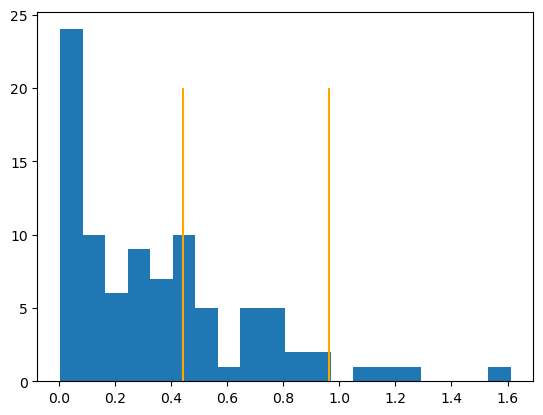

In [13]:
alphas = [0.05, 0.32] #定义两个alpha值
#在这里设置 method='higher' 是一个细节，确保我们实际得到与 MAPIE 实现中相同的分位数
quantiles = [np.nanquantile(scores, 1.0-alpha, method='higher') for alpha in alphas] #计算scores的两个分位数，1.0-alpha表示计算 (1-alpha) 分位数
print(scores)
print(quantiles)
plt.hist(scores, bins=20) #绘制scores的直方图，分为20个柱
plt.vlines(quantiles, ymin=0, ymax=20, color='orange') #在直方图上绘制垂直线，位置位计算得到的分位数quantiles
plt.show()

最后将这些分位数加到或减去均值预测 $\hat{\mu}(X)$ 上，从而得到所需的误差区间。

直观上，这非常合理！如果用$0.95$分位数捕捉校准集中95%的预测误差，那么这应该是具有相同覆盖保证的预测区间的一个好候选。这里使用校准集而不是训练集，因为否则可能会低估误差。这是因为模型拟合的目的是减少这些误差，因此会引入偏差。

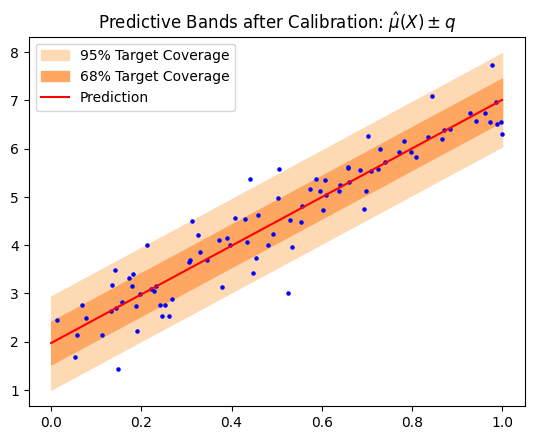

In [11]:
#绘制带有不确定性预测区间的回归图，这里红线是所有数据的预测值，蓝色散点是带噪声的函数输出（只取校准集部分），黄色和橘色是两种不同alpha的估计误差，来源于所有数据（包含训练预测和校准）和绝对误差分位数

mean_prediction = mean_predictor.predict(X) #在所有数据上进行预测（包含训练集、校准集和测试集）
prediction_bands = construct_prediction_bands(mean_prediction, quantiles) #构造不确定性预测区间，来自于自定义函数，分位数是quantiles，真实值是所有数据的预测值

fig, ax = plt.subplots(1, 1) #创建一个画布
regression_plot_with_uncertainty(
    ax,
    X,
    mean_prediction,
    prediction_bands,
    (X_cal, y_cal),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
) #绘制回归图，X为所有数据，mean_prediction为均值预测值（所有数据的预测值），prediction_bands为不确定性预测区间，(X_cal, y_cal)为校准集，quantiles为分位数，标签为95%目标覆盖率和68%目标覆盖率
ax.set_title(r'Predictive Bands after Calibration: $\hat{\mu}(X) \pm q$') #设置标题
plt.show()

这些区间比真实值的区间稍大，因为由于采样不确定性，校准集中落在95%误差范围之外的点数超过了预期数量

根据设计，我们在校准集和测试集上应该大致有 ($1-\alpha$) 的覆盖率。让我们再检查一遍

In [12]:
def compute_coverage(y, prediction_bands):
    num_points_outside = np.sum((y < prediction_bands[:,0]) | (y > prediction_bands[:,1]))
    coverage_score = 1.0-num_points_outside/len(y)
    return coverage_score

In [13]:
cal_prediction_bands = construct_prediction_bands(cal_mean_prediction, quantiles)
test_mean_prediction = mean_predictor.predict(X_test)
test_prediction_bands = construct_prediction_bands(test_mean_prediction, quantiles)

for i, alpha, q in zip(list(range(len(quantiles))), alphas, quantiles):
    print()
    print(f'Alpha: {alpha} (Target coverage: {(1.0-alpha)*100:.2f}%)')
    print('-'*50)
    coverage = compute_coverage(y_cal, cal_prediction_bands[:,:,i])
    print(f"Actual coverage on the calibration set: {coverage * 100:.2f}%")
    coverage = compute_coverage(y_test, test_prediction_bands[:,:,i])
    print(f"Actual coverage on the test set: {coverage * 100:.2f}%")


Alpha: 0.05 (Target coverage: 95.00%)
--------------------------------------------------
Actual coverage on the calibration set: 95.56%
Actual coverage on the test set: 96.00%

Alpha: 0.32 (Target coverage: 68.00%)
--------------------------------------------------
Actual coverage on the calibration set: 68.89%
Actual coverage on the test set: 74.00%


Most of the values look quite good! But why does the actual coverage on the test set deviate so much for $\alpha=0.32$? There are two reasons for this deviation:

1) The score quantiles were obtained using a finite calibration set of a given size. The larger this set, the better our estimation of the quantiles and the less variance we get for test coverage (see Section 2.3 of [this manuscript](https://www.stat.berkeley.edu/~ryantibs/statlearn-s23/lectures/conformal.pdf)).
2) The coverage guarantees that we get are probabilistic meaning that they hold on average. We can still draw unlucky test samples for which the observed coverage deviates, but this becomes less of an issue when the test set size increases.

## Comparison against MAPIE

Finally, we want to double check whether our implementation matches the one from MAPIE.

In [14]:
# MAPIE code to fit the same model

from mapie.regression import MapieRegressor
from mapie.conformity_scores import AbsoluteConformityScore

# By default conformity_score=None => AbsoluteConformityScore is used
# See here for a documentation: https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html
mapie_regressor = MapieRegressor(mean_predictor, conformity_score=None, cv='prefit', method='base')
mapie_regressor.fit(X_cal, y_cal)
y_pred, y_pis = mapie_regressor.predict(X, alpha=alphas)

Let's start by verifying whether our manually computed prediction bands are indeed equal up to $\epsilon$.

In [15]:
epsilon = 1e-12
proportion_equal_vals = np.mean( np.abs(y_pis-prediction_bands) < epsilon )
print(f'{proportion_equal_vals*100:.2f}% of values are equal.')

100.00% of values are equal.


That looks good! Our implementation seems to be correct!

For completeness, let's also confirm that we obtain the same plot as before. For a clearer comparison, we put them side by side. This time we plot the test points instead of the calibration points.

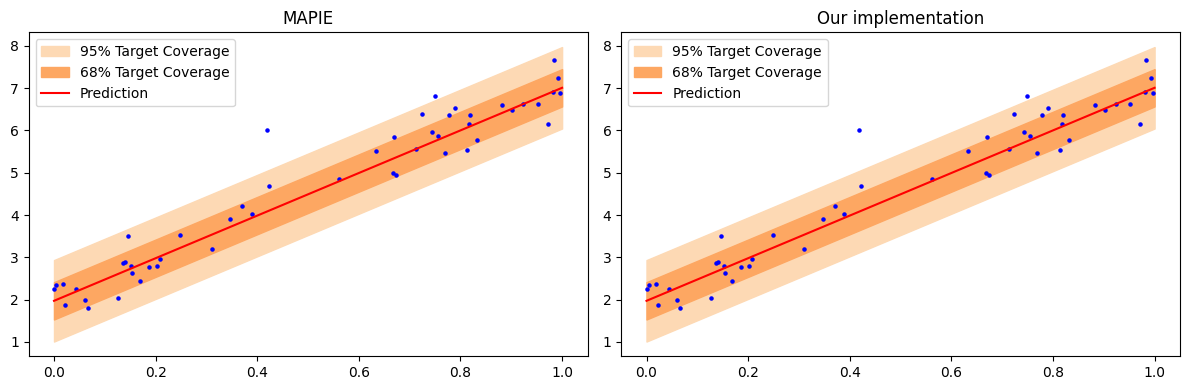

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
regression_plot_with_uncertainty(
    ax[0],
    X,
    y_pred,
    y_pis,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

regression_plot_with_uncertainty(
    ax[1],
    X,
    mean_prediction,
    prediction_bands,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

ax[0].set_title('MAPIE')
ax[1].set_title('Our implementation')
plt.tight_layout()
plt.show()

Constant prediction bands worked very well in this example because the noise was homoscedastic and we knew that the ground-truth model was indeed linear. In practice however, it can happen that the noise is either heteroscedastic or that our fitted model only matches the ground-truth in certain input regions. In both cases, it would be beneficial to capture predictive uncertainties that can vary between input regions. We will cover an approach to achieve this in the next notebook.